# Offline classification model training

This notebook describe the CNN training for performing the gait representation (GEI) classification task. For replication purposes, is recommended to run this notebook on [Google Colab](https://colab.research.google.com/?hl=en) making use of the GPU runtime.

## Preparing the environment for TensorRT with GPU usage

In [1]:
%%bash
pip install pillow matplotlib
pip install tensorflow-gpu==2.0.0
pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 380.8 MB 42 kB/s 
     |████████████████████████████████| 50 kB 7.9 MB/s 
     |████████████████████████████████| 449 kB 74.2 MB/s 
     |████████████████████████████████| 3.8 MB 56.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=65aef66bdce1aa8cfd53f4b4a1a4a6799476bf3458c2dfbae52a90f7f26caf67
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
 

In [2]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer5

Selecting previously unselected package nvidia-machine-learning-repo-ubuntu1804.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4

--2022-08-28 01:10:15--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’

     0K ..                                                    100%  142M=0s

2022-08-28 01:10:15 (142 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’ saved [2926/2926]

W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list.d/nvidia-machine-learning.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list.d/nvidia-machine-learni

In [3]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorRT version: 
ii  libnvinfer5                             5.1.5-1+cuda10.1                    amd64        TensorRT runtime libraries


In [4]:
!unzip /content/training_representations.zip

Archive:  /content/training_representations.zip
   creating: training_representations/
   creating: training_representations/004/
  inflating: training_representations/004/060-nm-02-4.png  
  inflating: training_representations/004/060-nm-03-2.png  
  inflating: training_representations/004/060-nm-03-1.png  
  inflating: training_representations/004/060-nm-02-2.png  
  inflating: training_representations/004/060-nm-01-1.png  
  inflating: training_representations/004/060-nm-00-1.png  
  inflating: training_representations/004/060-nm-02-3.png  
  inflating: training_representations/004/060-nm-01-2.png  
  inflating: training_representations/004/060-nm-04-2.png  
  inflating: training_representations/004/060-nm-02-1.png  
  inflating: training_representations/004/060-nm-04-1.png  
  inflating: training_representations/004/060-bg-03-2.png  
  inflating: training_representations/004/060-bg-03-1.png  
  inflating: training_representations/004/060-bg-02-2.png  
  inflating: training_represen

## Import libraries and pre-processing

In [19]:
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
datagenerator = ImageDataGenerator(rescale = 1/255,
                                   rotation_range=0.1, # rotation
                                   width_shift_range=0.005, # horizontal shift
                                   height_shift_range=0.005, # vertical shift
                                   horizontal_flip=True, # horizontal flip
                                   validation_split=0.2) 

In [14]:
training_data = '/content/training_representations'

img_height = 200
img_width = 200
batch_size = 16

train_ds = datagenerator.flow_from_directory(
    training_data,
    color_mode='grayscale',
    class_mode = "categorical",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset = "training"
)

val_ds = datagenerator.flow_from_directory(
    training_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode = "categorical",
    subset = "validation"
)

Found 1953 images belonging to 17 classes.
Found 479 images belonging to 17 classes.


In [15]:
classes = ['000','001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016']
print(classes)

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016']


In [16]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.axis("off")
  plt.tight_layout()
  plt.show()

(16, 200, 200, 1)


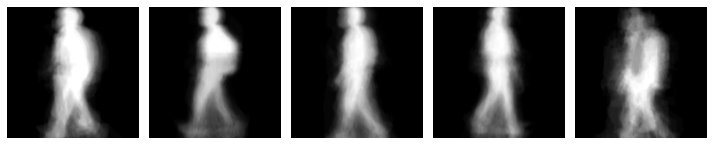

In [18]:
sample_training_images, _= next(iter(train_ds))
print(sample_training_images.shape)
plotImages(sample_training_images[:5])

## CNN model definition and training

In [78]:
model_cnn = keras.models.Sequential()

model_cnn.add(keras.layers.Conv2D(16, (3,3), padding='same'))
model_cnn.add(keras.layers.LeakyReLU(alpha=0.1))
model_cnn.add(keras.layers.BatchNormalization())
model_cnn.add(keras.layers.AveragePooling2D((2,2)))
model_cnn.add(keras.layers.Dropout(0.2))
model_cnn.add(keras.layers.Conv2D(32, (3,3), padding='same'))
model_cnn.add(keras.layers.LeakyReLU(alpha=0.1))
model_cnn.add(keras.layers.AveragePooling2D((2,2)))
model_cnn.add(keras.layers.Dropout(0.2))
model_cnn.add(keras.layers.Conv2D(64, (3,3), padding='same'))
model_cnn.add(keras.layers.LeakyReLU(alpha=0.1))
model_cnn.add(keras.layers.AveragePooling2D((2,2)))
model_cnn.add(keras.layers.Dropout(0.2))
model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same'))
model_cnn.add(keras.layers.LeakyReLU(alpha=0.1))
model_cnn.add(keras.layers.AveragePooling2D((2,2)))
model_cnn.add(keras.layers.Dropout(0.2))
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(32))
model_cnn.add(keras.layers.LeakyReLU(alpha=0.1))
model_cnn.add(keras.layers.Dropout(0.3))
model_cnn.add(keras.layers.Dense(len(classes), activation = "softmax"))

model_cnn.build((None, 200, 200, 1))
model_cnn.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           multiple                  160       
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   multiple                  0         
_________________________________________________________________
batch_normalization_3 (Batch multiple                  64        
_________________________________________________________________
average_pooling2d_72 (Averag multiple                  0         
_________________________________________________________________
dropout_33 (Dropout)         multiple                  0         
_________________________________________________________________
conv2d_73 (Conv2D)           multiple                  4640      
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   multiple                

In [79]:
optimizer = keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"
)

epochs = 70

model_cnn.compile(optimizer=optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
training_samples = train_ds.n
val_samples = val_ds.n
history_cnn = model_cnn.fit(
    train_ds,
    steps_per_epoch=training_samples // batch_size,
    epochs = epochs,
    validation_data=val_ds,
    validation_steps=val_samples // batch_size,
)

Train for 122 steps, validate for 29 steps
Epoch 1/70
122/122 [==============================] - 11s 88ms/step - loss: 2.8206 - accuracy: 0.0743 - val_loss: 2.8233 - val_accuracy: 0.1746
Epoch 2/70
122/122 [==============================] - 10s 85ms/step - loss: 2.7609 - accuracy: 0.1084 - val_loss: 2.7741 - val_accuracy: 0.2026
Epoch 3/70
122/122 [==============================] - 10s 78ms/step - loss: 2.6737 - accuracy: 0.1549 - val_loss: 2.6876 - val_accuracy: 0.2241
Epoch 4/70
122/122 [==============================] - 10s 79ms/step - loss: 2.5982 - accuracy: 0.1616 - val_loss: 2.5772 - val_accuracy: 0.2306
Epoch 5/70
122/122 [==============================] - 10s 78ms/step - loss: 2.5300 - accuracy: 0.1843 - val_loss: 2.3426 - val_accuracy: 0.2392
Epoch 6/70
122/122 [==============================] - 10s 78ms/step - loss: 2.4446 - accuracy: 0.2091 - val_loss: 2.3336 - val_accuracy: 0.2134
Epoch 7/70
122/122 [==============================] - 10s 79ms/step - loss: 2.3687 - accuracy

In [80]:
def visualizacion_resultados(history):
  nepochs = [i for i in range(epochs)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(nepochs, train_acc, "go-", label =" Entrenamiento accuracy")
  ax[0].plot(nepochs, val_acc, "ro-", label= "Validacion accuracy")
  ax[0].set_title("Entrenamiento & validación accuracy")
  ax[0].legend()
  ax[0].set_xlabel("nEpochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(nepochs, train_loss, "go-", label =" Entrenamiento Loss")
  ax[1].plot(nepochs, val_loss, "ro-", label= "Validacion Loss")
  ax[1].set_title("Entrenamiento & validación Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()


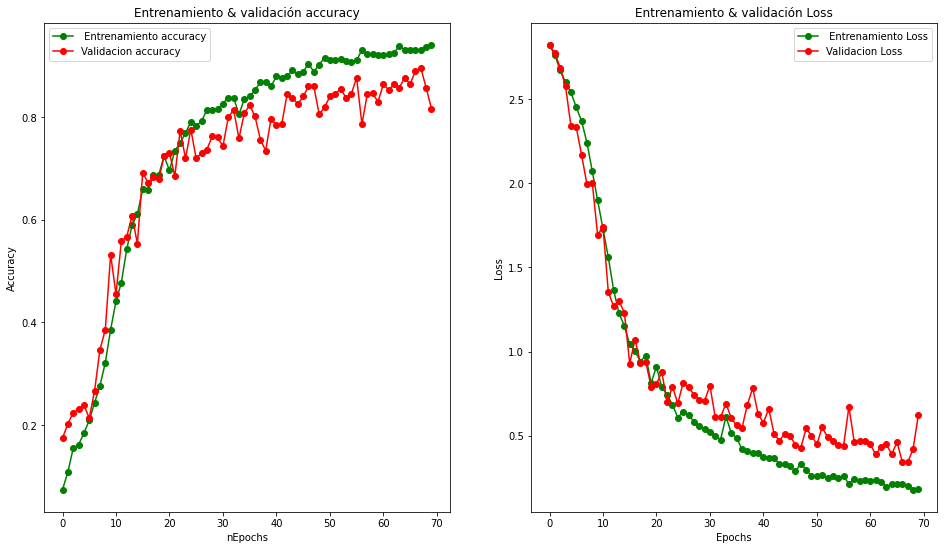

In [81]:
visualizacion_resultados(history_cnn)

## Validation set metrics

16/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 770us/sample - loss: 0.3524 - accuracy: 0.8750


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       0.00      0.00      0.00         0
           7       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1

    accuracy                           0.88        16
   macro avg       0.79      0.81      0.79        16
weighted avg       0.91      0.88      0.88        16



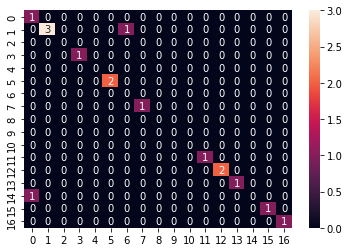

In [83]:
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
import seaborn as sns
import sklearn.metrics as metrics

test_batch = []
for data in next(val_ds):
  test_batch.append(data)

image_batch = test_batch[0]
label_batch = test_batch[1] 

loss, accuracy = model_cnn.evaluate(image_batch, label_batch)
predictions = np.argmax(model_cnn.predict(image_batch), axis=1)
label_batch = np.argmax(label_batch, axis=1)
cf_matrix = tf.math.confusion_matrix(label_batch, predictions)
sns.heatmap(cf_matrix, annot=True)
f1_score = metrics.classification_report(label_batch, predictions)
print(f1_score)

In [84]:
model_cnn.save("cnn_gait_recognition")

## Convert Keras model into TensorRT model

This section will describe the process for converting the saved Keras model into a TensorRT model capable of being deployed in the Jetson Nano GPU. This part of the notebook is based on the following colab notebook [Step1_Colab_TensorRT](https://colab.research.google.com/github/Tony607/tf_jetson_nano/blob/master/Step1_Colab_TensorRT.ipynb).

### Optimize for FP16 with TensorRT

In [85]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='cnn_gait_recognition', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='cnn_gait_recognition_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
Done Converting to TF-TRT FP16


In [86]:
!saved_model_cli show --all --dir cnn_gait_recognition_TFTRT_FP16


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 200, 200, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_1'] tensor_info:
        dtype: DT_FLOAT
        shape: unknown_rank
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict


### Keras vs. TensorRT inference speed comparison

In [88]:
img_path = '/content/016-075-cl-04-2.png'
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
image = image/255.0
GEI = tf.reshape(image, [-1,200,200,1])
GEI = tf.dtypes.cast(GEI, tf.float32)

In [89]:
saved_model_loaded = tf.saved_model.load('cnn_gait_recognition_TFTRT_FP16', tags=[tag_constants.SERVING])
signature_keys = list(saved_model_loaded.signatures.keys())
print(signature_keys)

['serving_default']


In [90]:
infer = saved_model_loaded.signatures['serving_default']
print(infer.structured_outputs)

{'output_1': TensorSpec(shape=<unknown>, dtype=tf.float32, name='output_1')}


In [103]:
import time 
import numpy as np

start_time = time.time()
pred = model_cnn(GEI)
end_time = time.time()

print(int(tf.argmax(pred,axis=1)))
print((end_time-start_time)*1000,' ms')

16
15.09404182434082  ms


In [105]:
start_time = time.time()
pred = infer(GEI)
end_time = time.time()

print(int(tf.argmax(np.asarray(pred['output_1']),axis=1)))
print((end_time-start_time)*1000,' ms')

16
1.5056133270263672  ms


In [106]:
!zip -r cnn_gait_recognition_TFTRT_FP16.zip cnn_gait_recognition_TFTRT_FP16

  adding: cnn_gait_recognition_TFTRT_FP16/ (stored 0%)
  adding: cnn_gait_recognition_TFTRT_FP16/saved_model.pb (deflated 12%)
  adding: cnn_gait_recognition_TFTRT_FP16/variables/ (stored 0%)
  adding: cnn_gait_recognition_TFTRT_FP16/variables/variables.index (deflated 59%)
  adding: cnn_gait_recognition_TFTRT_FP16/variables/variables.data-00001-of-00002 (deflated 8%)
  adding: cnn_gait_recognition_TFTRT_FP16/variables/variables.data-00000-of-00002 (deflated 78%)
  adding: cnn_gait_recognition_TFTRT_FP16/assets/ (stored 0%)
